In [63]:
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from pattern.es import lemma
from nltk.stem import WordNetLemmatizer

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import joblib

In [2]:
psy=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube01-Psy.csv")
kp=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube02-KatyPerry.csv")
lmfao=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube03-LMFAO.csv")
eminem=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube04-Eminem.csv")
shakira=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube05-Shakira.csv")

doc=pd.concat([psy,kp,lmfao,eminem,shakira],axis=0,ignore_index=True)
doc.shape

(1956, 5)

In [3]:
# Total 1005 spams
doc['CLASS'].value_counts(normalize=True)

1    0.513804
0    0.486196
Name: CLASS, dtype: float64

In [4]:
def clean_text(text):
    nonpunc = [char for char in text if char not in string.punctuation]
    nonpunc = ''.join(nonpunc).lower()
    return[word for word in nonpunc.split() if word not in stopwords.words('english')]


class LemmaTokenizer(object):
    def __call__(self, text):
        return [lemma(t) for t in word_tokenize(text)]

In [64]:
def custom_preprocessor(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    # stem words
    lemmatizer=WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
#     return text

In [89]:
%%time
countVectorizer=CountVectorizer(decode_error='ignore',preprocessor=custom_preprocessor,lowercase=False, stop_words='english',
                                ngram_range=(1,2))
tfTransformer=TfidfTransformer()

Wall time: 0 ns


In [110]:
# xgb=XGBClassifier(max_depth=3,n_jobs=-1,n_estimators=40)
xgb=RandomForestClassifier(n_estimators=10,max_depth=3)

steps=[('countVectorizer',countVectorizer),
#                     ('tfTransformer',tfTransformer),
                   ('xgb',xgb)]
pipe = Pipeline(steps)

X_train=doc['CONTENT'].astype(str)
y_train=doc['CLASS'].astype(str)

pipe.fit(X_train,y_train);

In [177]:
test=pd.read_excel('Data/Comments.xlsx')

X_test=test['Comment'].astype('str')

predictions = pipe.predict(X_test)
predictionProbability=pipe.predict_log_proba(X_test)
predictionProbability

test['Predictions']=pd.DataFrame(predictions.astype(int))
test['predictionProbability0']=pd.DataFrame(predictionProbability[:,0])
test['predictionProbability1']=pd.DataFrame(predictionProbability[:,1])

In [218]:
# filter comments classified as spam but the probability difference is miniscule. 
# After scanning through these comments , it came out that most of these are non-spam comments

filt=test['Predictions']==1
filt2=abs(test['predictionProbability0']-test['predictionProbability1'])<.015
test.loc[filt & filt2].shape

(0, 9)

In [219]:
# Updating the rows from above filter
test.loc[filt & filt2,['Predictions']]=0

In [222]:
filt=test['Predictions']==0
filt2=abs(test['predictionProbability0']-test['predictionProbability1'])<.015
test.loc[filt & filt2].head()

,Video Title,Comment,CommentID,Author,Replies,Likes,Predictions,predictionProbability0,predictionProbability1
2,Taylor Swift - Blank Space,Part 1 :Blank Space<br />Part 2 :Me! <br />Jus...,Ugyf1Jy65j0jckmFbNZ4AaABAg,Mary Villanueva,0,0,0,-0.697971,-0.688347
13,Taylor Swift - Blank Space,Who else pays no attention to the music and ju...,UgyQyuvIr6z4hQyYkj94AaABAg,Alana Houchens,0,0,0,-0.695006,-0.691292
20,Taylor Swift - Blank Space,How can you not love Taylor swift <br /><br />...,UgwBe0FaBOHRgf6zE794AaABAg,Adarsh Shukla,0,0,0,-0.697971,-0.688347
21,Taylor Swift - Blank Space,one day before my birthday this video come out...,UgzUOr_wV1D8oeSFwIt4AaABAg,Sofia Sosa,0,1,0,-0.696303,-0.690001
23,Taylor Swift - Blank Space,ﺟﺎﺭﻱ البحث عن من يصلي علي الرسولﷺ<br /><br />L...,Ugz8BVnBYc_SoBvf8W14AaABAg,جبار الطائي,0,0,0,-0.697971,-0.688347


In [225]:
test['Predictions'].value_counts()

0    4762
1     238
Name: Predictions, dtype: int64

In [226]:
filt=test['Predictions']==0
test_nonSpam=test[filt]
test_nonSpam.shape

(4762, 9)

### Sentiment Analysis Using VaderSentiment


In [228]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [247]:
analyzer=SentimentIntensityAnalyzer()
analyzer.polarity_scores('I love it')['compound']

0.6369

In [254]:
doc=pd.DataFrame([])
for i in range(test.shape[0]):
    doc=doc.append(pd.DataFrame(analyzer.polarity_scores(test['Comment'][i]),index=[0]))

In [255]:
test['Comment'][2]

'Part 1 :Blank Space<br />Part 2 :Me! <br />Just notice.'

In [260]:
test['Polarity']=doc['compound'].reset_index(drop=True)
test.head()

,Video Title,Comment,CommentID,Author,Replies,Likes,Predictions,predictionProbability0,predictionProbability1,Polarity
0,Taylor Swift - Blank Space,i love,Ugy-PtcBo7vqVTrEXHt4AaABAg,Nzuzi Mukinayi,0,0,0,-0.624846,-0.766457,0.6369
1,Taylor Swift - Blank Space,Bart Baker&#39;s parody is better,UgzpviQOjx1-uTS6XP94AaABAg,Blue_ Danu,0,0,0,-0.624846,-0.766457,0.4404
2,Taylor Swift - Blank Space,Part 1 :Blank Space<br />Part 2 :Me! <br />Jus...,Ugyf1Jy65j0jckmFbNZ4AaABAg,Mary Villanueva,0,0,0,-0.697971,-0.688347,0.0000
3,Taylor Swift - Blank Space,😑😐🤔🤔🤔🤔🤔🤔🤔🤔🤔😣😥😶😮🤔🤔🥉🥉🚼🚻🚺🚹,Ugy3-38V-k8RZgxZJBl4AaABAg,Bertha Perez,0,0,0,-0.624846,-0.766457,0.0000
4,Taylor Swift - Blank Space,"2020 <a href=""https://www.youtube.com/watch?v=...",UgxiBHYbr4Sjoa39NmV4AaABAg,WEST L I F E LOVER,0,0,1,-1.069903,-0.420135,0.5473


In [291]:
filt=test['Polarity']<.5 
filt2= test['Polarity']==0
test.loc[filt2,['Comment','Polarity']].tail()

,Comment,Polarity
4992,😲😲😲,0.0
4993,Oh billions,0.0
4996,Hola,0.0
4997,Who’s here to listen to there child hood songs...,0.0
4999,&lt;3,0.0


In [285]:
test['Sentiment']=np.where(test['Polarity']==0,'UNC',np.where(test['Polarity']>0,'POS','NEG'))

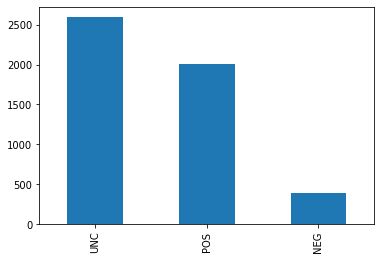

In [289]:
test['Sentiment'].value_counts().plot(kind='bar');

### Cluster Analaysis